In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from bayesmodels import CalibrationModel
from tensorflow_probability.python import distributions  as tfd
import tensorflow as tf

In [2]:
# load data 
datasim = np.loadtxt('../testData/datasim.txt')
dataexp = np.loadtxt('../testData/dataexp.txt')

print(datasim.shape, dataexp.shape)

(65, 3) (30, 2)


In [3]:
sim_inputs = datasim[:,:-1]
sim_outputs = datasim[:,-1]

exp_inputs = dataexp[:,:-1]
exp_outputs = dataexp[:,-1]

print(sim_inputs.shape, sim_outputs.shape, exp_inputs.shape, exp_outputs.shape)

(65, 2) (65,) (30, 1) (30,)


In [4]:
model = CalibrationModel(sim_inputs, sim_outputs, exp_inputs, exp_outputs, 
                         model_info = None, kernel_types = ['RBF', 'RBF', 'Matern32'],
                         noise_level = 5e-4, labels = ["x", "theta"], output_label = "y")

## Getting some info 

In [5]:
# Info on priors 
info_dict = model.describe_priors()

In [6]:
for key in info_dict:
    print(info_dict[key], "\n")

tfp.distributions.Independent("calibration_model_sim_kernel_features_hyp_rv_beta", batch_shape=[], event_shape=[1], dtype=float32) 

tfp.distributions.Gamma("calibration_model_sim_kernel_features_hyp_rv_vark", batch_shape=[], event_shape=[], dtype=float32) 

tfp.distributions.Independent("calibration_model_sim_kernel_parameters_hyp_rv_beta", batch_shape=[], event_shape=[1], dtype=float32) 

tfp.distributions.Independent("calibration_model_disc_kernel_rv_beta", batch_shape=[], event_shape=[1], dtype=float32) 

tfp.distributions.Gamma("calibration_model_disc_kernel_rv_vark", batch_shape=[], event_shape=[], dtype=float32) 

tfp.distributions.Independent("calibration_model_rv_par", batch_shape=[], event_shape=[1], dtype=float32) 

tfp.distributions.Normal("calibration_model_rv_loc", batch_shape=[], event_shape=[], dtype=float32) 



In [7]:
# Info on moments of priors 
info_dict = model.compute_moments_of_priors()

In [8]:
for key in info_dict:
    print(key, info_dict[key], "\n")

calibration_model/sim_kernel/features_hyp/beta {'mean': array([1.], dtype=float32), 'variance': array([0.33333334], dtype=float32)} 

calibration_model/sim_kernel/vark {'mean': 1.0, 'variance': 0.06666667} 

calibration_model/sim_kernel/parameters_hyp/beta {'mean': array([1.], dtype=float32), 'variance': array([0.33333334], dtype=float32)} 

calibration_model/disc_kernel/beta {'mean': array([1.], dtype=float32), 'variance': array([0.33333334], dtype=float32)} 

calibration_model/disc_kernel/vark {'mean': 1.0, 'variance': 0.06666667} 

calibration_model/par {'mean': array([0.01837128], dtype=float32), 'variance': array([0.9716572], dtype=float32)} 

calibration_model/loc {'mean': 0.0, 'variance': 0.010000001} 



In [9]:
# Update prior and initial state  of discrepancy variance 
hyp_name = 'calibration_model/disc_kernel/vark'
new_prior = tfd.Gamma(concentration = 7.0, rate = 14.0,  name = hyp_name)
model.update_prior(hyp_name, new_prior)
info_dict = model.compute_moments_of_priors()
key = hyp_name
print(key, info_dict[key], "\n")

model.update_initial_state(hyp_name, 0.5)
info_dict = model.get_initial_state()
key = hyp_name
print(key, info_dict[key], "\n")

calibration_model/disc_kernel/vark {'mean': 0.5, 'variance': 0.035714287} 

calibration_model/disc_kernel/vark 0.5 



In [10]:
# Update prior and initial state  inverse lengthscale of discrepancy kernel
hyp_name = 'calibration_model/disc_kernel/beta'
new_prior = tfd.Independent(tfd.Gamma(concentration = 3*tf.ones(model.dim_features, tf.float32),
                          rate = 3*tf.ones(model.dim_features, tf.float32)),
                        reinterpreted_batch_ndims=1, name = hyp_name)
model.update_prior(hyp_name, new_prior)
info_dict = model.compute_moments_of_priors()
key = hyp_name
print(key, info_dict[key], "\n")

new_initial_state = 0.5*tf.ones(model.dim_features, tf.float32)
model.update_initial_state(hyp_name, new_initial_state)
info_dict = model.get_initial_state()
key = hyp_name
print(key, info_dict[key], "\n")

calibration_model/disc_kernel/beta {'mean': array([1.], dtype=float32), 'variance': array([0.33333334], dtype=float32)} 

calibration_model/disc_kernel/beta tf.Tensor([0.5], shape=(1,), dtype=float32) 



## Run  mcmc

In [11]:
mcmc_samples = 6000
num_burnin_steps = 10000
num_adaptation_steps = 5000
adaptation_rate = 0.50
init_step_size = 0.15
num_leapfrog_steps = 2
thinning = 2


model.run_mcmc(mcmc_samples, num_burnin_steps, num_adaptation_steps,
              adaptation_rate, init_step_size, num_leapfrog_steps,thinning)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Average acceptance ratio:  0.74002326


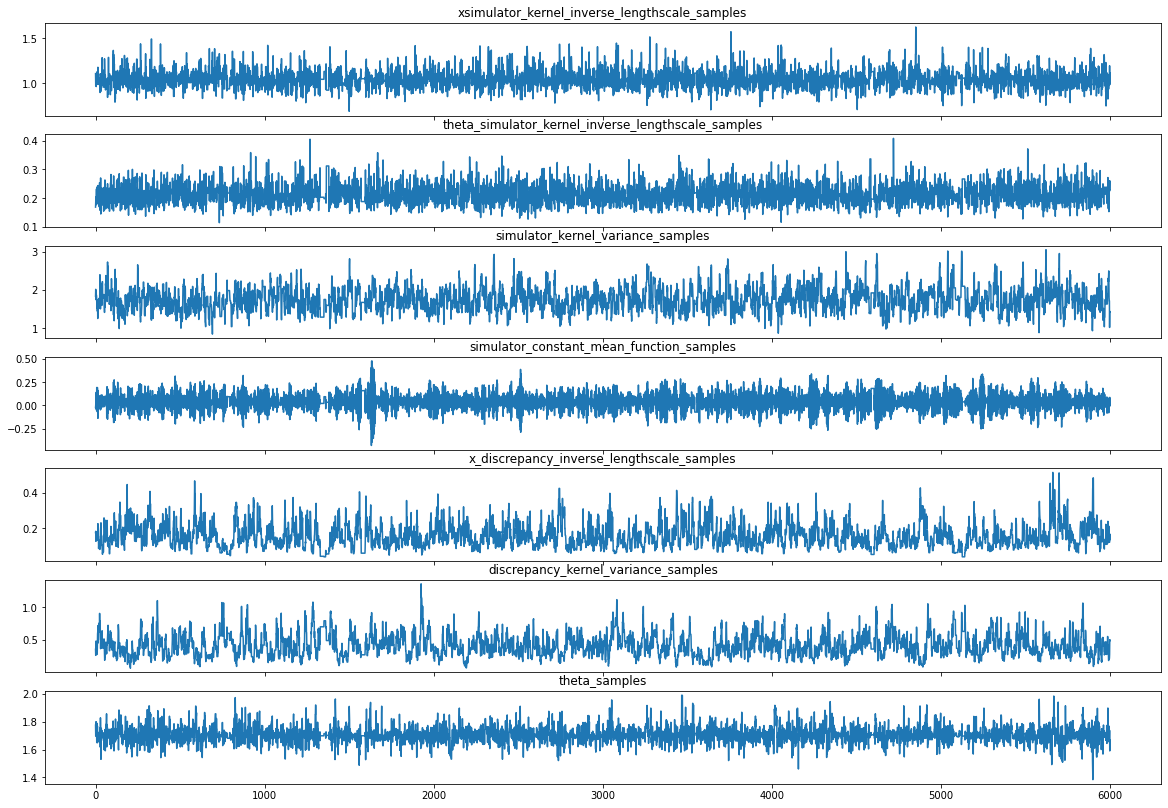

In [12]:
model.plot_chains()

<Figure size 864x864 with 0 Axes>

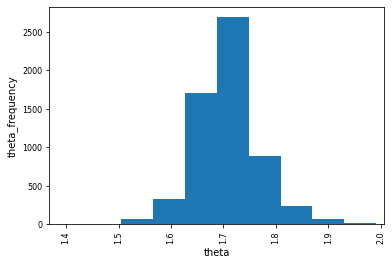

In [13]:
model.get_parameter_correlations_plot()

## Inference

In [14]:
mean_full, std_full = model.get_predictions(exp_inputs, type= "full", fast = False)
mean_sim, std_sim =  model.get_predictions(exp_inputs, type= "simulator", fast =False)
mean_disc, std_disc =  model.get_predictions(exp_inputs, type= "discrepancy", fast = False)

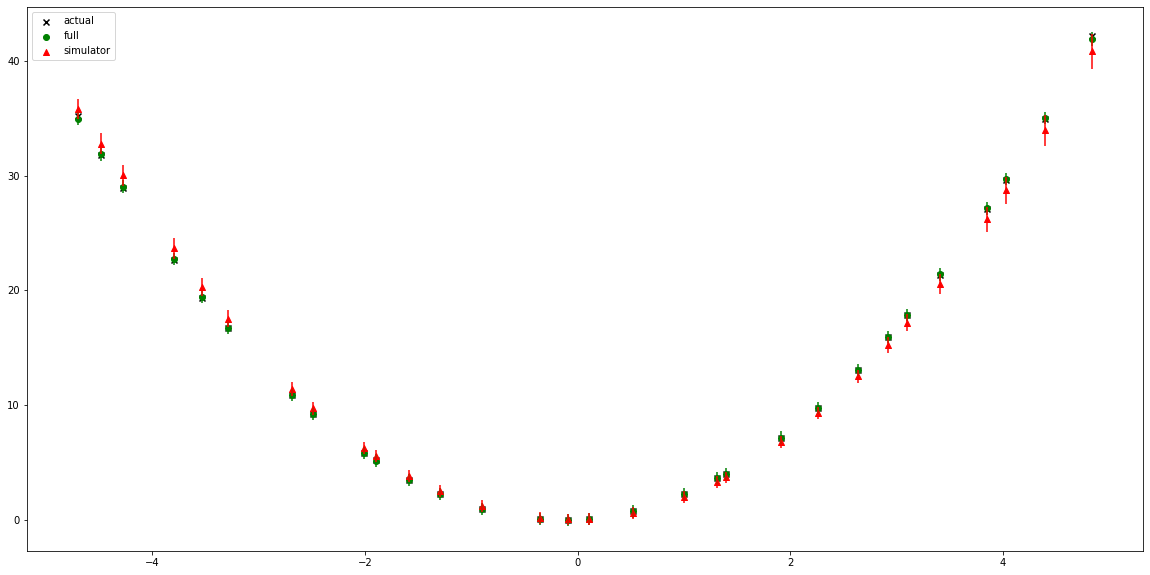

In [15]:
plt.figure(figsize =(20,10))
plt.scatter(exp_inputs, exp_outputs, color = 'k', marker = 'x', label = "actual")
plt.scatter(exp_inputs, mean_full, color = 'g', marker = 'o', label = "full")
plt.vlines(exp_inputs, mean_full -2*std_full, mean_full +2*std_full,  color = 'g')
plt.scatter(exp_inputs, mean_sim, color = 'r', marker = '^', label = "simulator")
plt.vlines(exp_inputs, mean_sim -2*std_sim, mean_sim +2*std_sim,  color = 'r')
plt.legend()

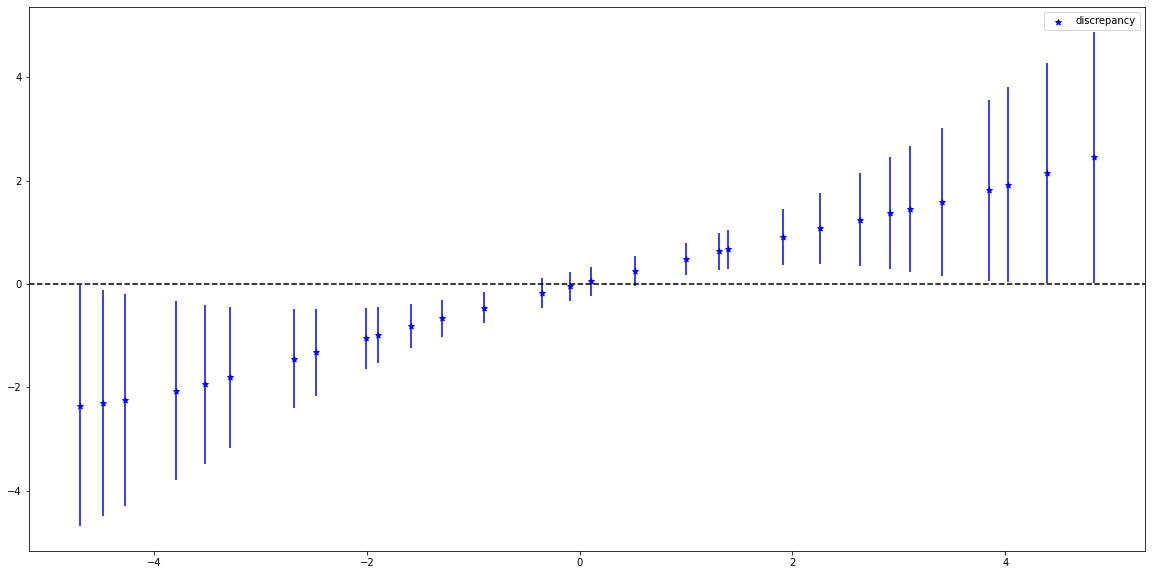

In [16]:
plt.figure(figsize =(20,10))
plt.scatter(exp_inputs, mean_disc, color = 'b', marker = '*', label = "discrepancy")
plt.vlines(exp_inputs, mean_disc -2*std_disc, mean_disc +2*std_disc,  color = 'b')
plt.axhline(y=0.0, color='k', linestyle='--')
plt.legend()